# Characterizing Raster Data around Buffered Spatial Points

Author: Matt Oakley

One important thing we can do with data in Raster format is calculate statistical values such as mean, standard deviation, variance, etc. around points in the data. By doing so, we're able to find out attributes about the data and can generalize areas of it as opposed to dealing with every single individual cell.

## Objectives

- Read in the data
- Extract a subset of points
- Compute statistics from these points

## Dependencies

- GDAL
- NumPy
- GeoPy
- Matplotlib

In [ ]:
!conda install gdal
!conda install numpy
!pip install geopy
!pip install utm

In [1]:
from __future__ import division
from geopy.geocoders import Nominatim
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import utm

%matplotlib inline

## Read in the Data

Our first objective is to read in the data that we want to use. We'll be working with .tiff image files and reading these in as numpy arrays. By doing so, we'll be able to essentially "view" our image as a 2D array where each cell corresponds to some value stored in each pixel of the image.

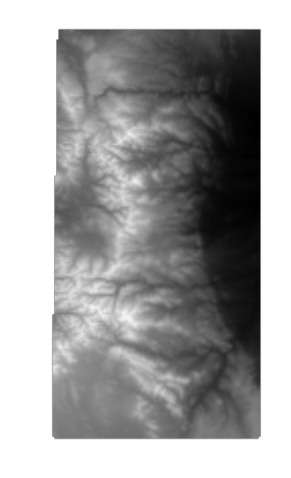

In [2]:
#Read in the data
filename = "../data/front_range_dem.tif"
gdal_data = gdal.Open(filename)
gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()
data_array = gdal_data.ReadAsArray()
data_array[data_array == nodataval] = np.nan

#View the data we're using
plt.figure(figsize = (8, 8))
plt.axis("off")
img = plt.imshow(data_array, cmap = "gray")

## Extracting a Subset of Points

Now that we've read in our data, we're ready to extract a subset of this data that we want to compute statistics on. In doing so, we'll be able to get averages and other attributes from an area of our data as opposed to simply looking at individual values from pixels. Let's extract these points from a circular buffer that we'll place onto the data.

We'll first need to define where to center our circle buffer. Let's do this by using the central lat/lon coordinates for Boulder, CO which we'll get by using the GeoPy module.

In [3]:
#Retrieve the UTM coordinates of where we want to center our circle
def get_UTM_coordinates(city_name):
    geolocator = Nominatim()
    latlon = geolocator.geocode(city_name)
    UTM_coords = utm.from_latlon(latlon.latitude, latlon.longitude)
    return UTM_coords

UTM_coords = get_UTM_coordinates("Boulder, CO")
print "Boulder UTM Easting:", UTM_coords[0]
print "Boulder UTM Northing:", UTM_coords[1]

Boulder UTM Easting: 476911.351468
Boulder UTM Northing: 4429455.52625


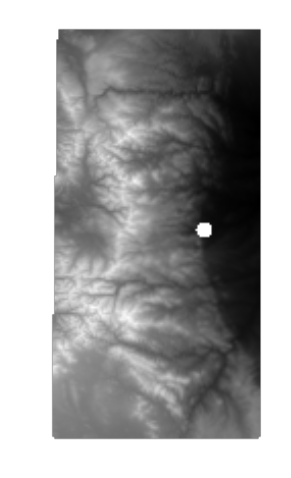

In [4]:
#Get row and column in raster based upon UTM coordinates
#This is where we'll center the circle
def get_coords_at_point(rasterfile, pos):
    gdata = gdal.Open(rasterfile)
    gt = gdata.GetGeoTransform()
    data = gdata.ReadAsArray().astype(np.float)
    row = int((pos[0] - gt[0])/gt[1])
    col = int((pos[1] - gt[3])/gt[5])
    return col, row

#Extract the points within the circle
def points_in_circle(circle, arr):
    buffer_points = []
    i0, j0, r = circle
    
    def int_ceiling(x):
        return int(np.ceil(x))
    
    for i in xrange(int_ceiling(i0 - r), int_ceiling(i0 + r)):
        ri = np.sqrt(r**2 - (i - i0)**2)
        
        for j in xrange(int_ceiling(j0 - ri), int_ceiling(j0 + ri)):
            buffer_points.append(arr[i][j])
            arr[i][j] = np.nan
    
    return buffer_points

center = (UTM_coords[0], UTM_coords[1])
radius = 4

row, col = get_coords_at_point(filename, center) 
circle = (row, col, radius)
buffer_points = points_in_circle(circle, data_array)

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
plt.axis("off")
img = plt.imshow(data_array, cmap = "gray")

## Compute Statistics

Now that we have all of the values within the buffer/area, we can very easily use NumPy to compute statistics such as mean, standard deviation, and variance on the data.

In [5]:
mean = np.nanmean(buffer_points)
std = np.nanstd(buffer_points)
variance = np.nanvar(buffer_points)

print "Mean: %.2f" % mean
print "Standard Deviation: %.2f" % std
print "Variance: %.2f" % variance

Mean: 1690.74
Standard Deviation: 95.51
Variance: 9121.32
